<a href="https://colab.research.google.com/github/Alxye/Anycost-GAN/blob/main/Anycost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install requirement
print('Installing PyTorch...')
! pip install torch 1>/dev/null
print('Installing torchvision...')
! pip install torchvision 1>/dev/null
print('Installing numpy...')
! pip install numpy 1>/dev/null
print('Installing tqdm (progress bar) ...')
! pip install tqdm 1>/dev/null
print('Installing matplotlib...')
! pip install matplotlib 1>/dev/null
print('All required packages have been successfully installed!')
# now clone the code
! git clone https://github.com/mit-han-lab/anycost-gan.git  

Installing PyTorch...
Installing torchvision...
Installing numpy...
Installing tqdm (progress bar) ...
Installing matplotlib...
All required packages have been successfully installed!
Cloning into 'anycost-gan'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 117 (delta 17), reused 38 (delta 10), pack-reused 56
Receiving objects: 100% (117/117), 26.06 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
# TODO
%cd anycost-gan

/content/anycost-gan


Ninja is required to load C++ extensions
 # Using native op...


Downloading: "https://hanlab.mit.edu/projects/anycost-gan/files/generator_anycost-ffhq-config-f.pt" to /root/.cache/torch/hub/checkpoints/generator_anycost-ffhq-config-f.pt


Downloading: "https://hanlab.mit.edu/projects/anycost-gan/files/generator_anycost-car-config-f.pt" to /root/.cache/torch/hub/checkpoints/generator_anycost-car-config-f.pt


(-0.5, 4504.5, 4299.5, -0.5)

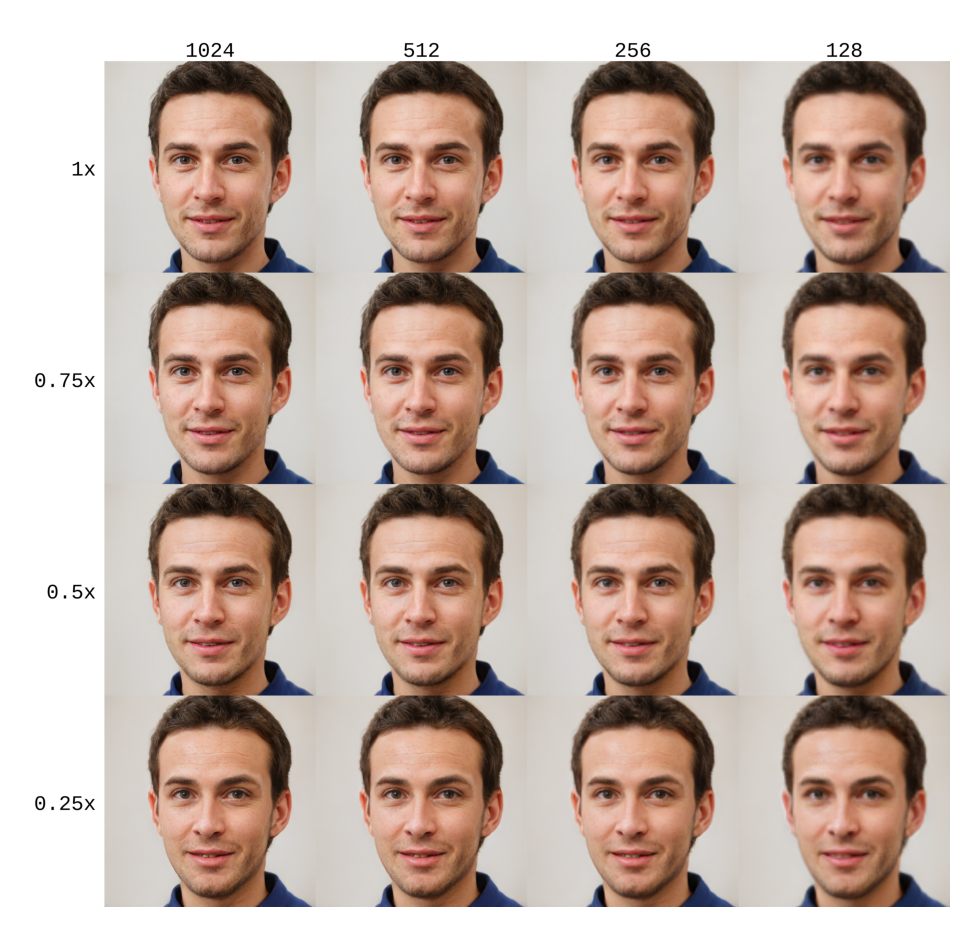

In [ ]:

#%matplotlib
import os
import torch
import torch.nn.functional as F
import numpy as np
from jedi.api.refactoring import inline
from tqdm import tqdm_notebook as tqdm
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200  # I would like to make it higher, but too slow
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageFont, ImageDraw

import models
from models.dynamic_channel import set_sub_channel_config, remove_sub_channel_config, set_uniform_channel_ratio, reset_generator

device = 'cuda'
font_path = '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf'

# load anycost generator (uniform)
g_ffhq = models.get_pretrained('generator', 'anycost-ffhq-config-f').to(device).eval()
g_car = models.get_pretrained('generator', 'anycost-car-config-f').to(device).eval()


def torch_to_np_image(x):
    assert x.shape[0] == 1
    x = x.squeeze(0)
    return ((x.permute(1, 2, 0) + 1) * 0.5 * 255).cpu().numpy().astype('uint8')


def add_legend_to_figure(x, full_res):
    # add padding
    h, w, c = x.shape
    x_pad_rate = 0.1
    y_pad_rate = 0.05
    pad_h = int(h + h * y_pad_rate)
    pad_w = int(w + w * x_pad_rate)
    pad_x = np.zeros([pad_h, pad_w, c], dtype=x.dtype)
    pad_x[...] = (255)
    pad_x[-h:, -w:] = x
    # add text
    img = Image.fromarray(pad_x)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, int(100 * full_res / 1024))

    for i, text in enumerate(['1x', '0.75x', '0.5x', '0.25x']):
        text_w, text_h = draw.textsize(text, font=font)
        x_coord = x_pad_rate * w * 0.9 - text_w
        y_coord = (y_pad_rate + i * 1. / 4 + 1. / 8) * h - 0.5 * text_h
        draw.text((x_coord, y_coord), text, (0, 0, 0), font=font)

    for i in range(4):
        text = str(full_res // (2 ** i))
        text_w, text_h = draw.textsize(text, font=font)
        x_coord = (x_pad_rate + i * 1. / 4 + 1. / 8) * w - 0.5 * text_w
        y_coord = y_pad_rate * h * 0.9 - text_h
        draw.text((x_coord, y_coord), text, (0, 0, 0), font=font)

    return np.asarray(img)


def get_4x4_grid(g, latent, truncation=0.5, crop=False):  # generate the image grid using z code (latent)
    images = []
    full_resolution = g.resolution
    if truncation < 1:
        mean_style = g.mean_style(10000)
    else:
        mean_style = None
    with torch.no_grad():
        for channel_mult in [1, .75, .5, .25]:
            set_uniform_channel_ratio(g, channel_mult)
            _, all_rgbs = g(latent, return_rgbs=True, truncation=truncation, truncation_style=mean_style,
                            randomize_noise=False)
            all_rgbs = all_rgbs[-4:][::-1]  # the largest 4 resolutions
            all_rgbs = [F.interpolate(rgb.clamp(-1, 1), size=(full_resolution, full_resolution), mode='bilinear',
                                      align_corners=True) for rgb in all_rgbs]
            if crop:  # for car dataset, crop out the padding of the image
                all_rgbs = [r[:, :, int(0.125 * full_resolution): -int(0.125 * full_resolution)] for r in all_rgbs]
            images.append(torch.cat(all_rgbs, dim=3))  # concat along width
    image_grid = torch.cat(images, dim=2)  # concat along height
    image_grid_np = torch_to_np_image(image_grid)
    return add_legend_to_figure(image_grid_np, full_resolution)

torch.manual_seed(1601)
latent = torch.randn(1, 1, 512, device=device)
img_out_np = get_4x4_grid(g_ffhq, latent)

plt.figure(figsize = (6,6))
plt.imshow(img_out_np)
plt.axis('off')